In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as nprnd
import scipy.optimize

%matplotlib inline

In [10]:
def normalization(data):
    return data * partial_count_target / np.mean(data['partial_count'])

In [11]:
def CV_function(data):
    if np.mean(data) > 0:
        return np.std(data) / np.mean(data)
    else :
        return 0

In [12]:
def map_unif_to_bern(unif, p):
    out = np.zeros(shape=unif.shape)
    out[unif >= p] = 1
    return out

In [13]:
def plot_hist(x, log=False, nbins=10, ra=None):
    if(log):
        x = np.log(x)/np.log(10)
    hist, bins = np.histogram(x, bins=nbins, range=ra)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()

In [5]:
ID = 1
beta = 1

# Importing Data

In [9]:
df = pd.read_csv('doublets-detection-dataset' + str(ID) + '.csv', header=None)
df = df.T
df.shape

(4593, 28205)

In [10]:
gene_index = df.iloc[0]
df = df[1:]

In [11]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,28195,28196,28197,28198,28199,28200,28201,28202,28203,28204
1,4,1,0,1,0,3,0,0,1,0,...,134,67,116,124,79,13,109,8,10,0
2,3,2,0,1,0,0,2,0,0,0,...,72,56,84,57,49,5,64,1,11,0
3,3,0,0,0,0,3,1,0,0,0,...,104,71,94,54,60,9,69,2,7,0
4,2,1,0,1,0,1,0,0,1,0,...,110,82,61,75,83,4,62,0,13,0
5,0,0,0,0,0,0,0,0,0,0,...,14,6,5,6,1,0,0,0,1,0


# Super Genes

In [15]:
gene_expression = df.sum(axis=0)
gene_expression[gene_expression <= 0] = 1e-8
gene_level_expression = gene_expression / np.float(np.sum(gene_expression))

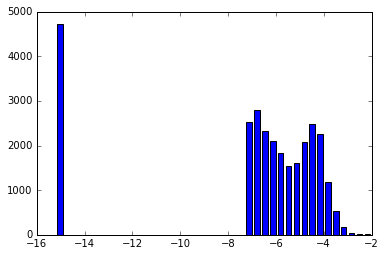

In [21]:
plot_hist(gene_level_expression, log=True, nbins=40)

In [24]:
super_gene_threshold = 0.005
super_genes = np.where(gene_level_expression >= super_gene_threshold)[0]
regular_genes = np.where(gene_level_expression < super_gene_threshold)[0]
super_genes

array([ 5523,  5658, 14174, 16939, 20477, 21001, 22795, 23014, 28192,
       28194, 28195, 28197], dtype=int64)

# Filtering Valid Cells

In [25]:
###  Order doublets - filtering cells
df['total_count'] = df.sum(axis=1)
df['partial_count'] = df[regular_genes].sum(axis=1)

In [26]:
df = df[df['total_count'] > 0]
np.mean(df['total_count'])

3403.1883710801394

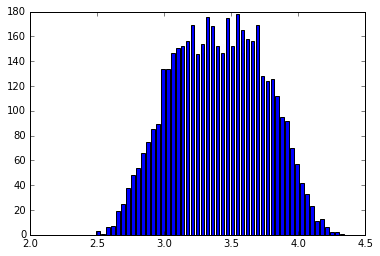

In [27]:
plot_hist(df['total_count'], log=True, nbins=50)

In [28]:
valid_cell_threshold = 1000
print np.mean(df['total_count'] >= valid_cell_threshold)
df = df[df['total_count'] >= valid_cell_threshold]
df.shape

0.866071428571


(3977, 28207)

# Marking presumed singlets

In [29]:
q_threshold = 95
q = np.percentile(df["total_count"], q_threshold)
presumed_singlets = np.array(df["total_count"] >= q, dtype=int)

# ---Creating doublets

In [30]:
N_doublets = 4000

In [31]:
indexes = nprnd.random_integers(0, df.shape[0]-1, size=2*N_doublets)
indexes = df.index[indexes]
indexes = np.reshape(indexes, (N_doublets, 2))
indexes.shape

(4000L, 2L)

In [32]:
def mix(serie):
    n = serie[indexes[:, 0]].as_matrix().astype(np.int) +  serie[indexes[:, 1]].as_matrix().astype(np.int)
    return list(nprnd.binomial((n/beta).astype(np.int), beta))

In [33]:
d = np.zeros(shape=(df.shape[1], N_doublets), dtype=np.int32)
d = df.apply(mix, axis=0)

In [34]:
del d['total_count']
del d['partial_count']

In [35]:
doublets = np.zeros(shape=(N_doublets, d.shape[0]))

In [36]:
for i in range(0, d.shape[0]):
    doublets[:, i] = np.array(d[i])

In [37]:
df_doublets = pd.DataFrame(data=doublets, index=np.arange(df.shape[0], 
                                                         N_doublets + df.shape[0]), columns = df.columns[:-2])
df_doublets.head()

,0,1,2,3,4,5,6,7,8,9,...,28195,28196,28197,28198,28199,28200,28201,28202,28203,28204
3977,2,0,0,0,0,1,0,0,0,0,...,91,58,78,57,42,12,41,3,7,0
3978,0,0,0,0,0,0,0,0,0,0,...,17,14,15,5,19,0,19,1,0,0
3979,0,0,0,0,0,5,0,0,1,0,...,30,25,44,14,20,4,30,1,10,0
3980,1,0,0,0,0,4,0,0,0,0,...,68,57,64,67,44,5,44,3,15,0
3981,0,0,0,0,0,3,0,0,0,0,...,33,37,33,46,31,3,42,0,7,0


In [38]:
df_doublets['total_count'] = df_doublets.sum(axis=1)
df_doublets['partial_count'] = df_doublets[regular_genes].sum(axis=1)

In [39]:
np.mean(df['total_count']), np.mean(df_doublets['total_count'])

(3814.1825496605484, 7642.14775)

In [40]:
np.mean(df_doublets['total_count'] <= valid_cell_threshold)

0.0

# Aggregating datasets

In [41]:
df_doublets['a_doublet'] = np.ones(shape=(N_doublets))
df['a_doublet'] = np.zeros(shape=(df.shape[0]))

In [42]:
df['p_singlet'] = presumed_singlets
df_doublets['p_singlet'] = np.zeros(shape=(N_doublets))

In [43]:
df = pd.concat([df, df_doublets])

In [44]:
df.shape

(7977, 28209)

In [45]:
df.to_pickle('whole_data')

In [2]:
df = pd.read_pickle('whole_data')

# Normalization

In [3]:
partial_count_target = np.mean(df['partial_count'])
partial_count_target
total_count = df["total_count"]

In [6]:
np.save("doublets-detection-dataset" + str(ID) + "_total_count", df['total_count'].as_matrix())
np.save("doublets-detection-dataset" + str(ID) + "_a_doublet_labels", df['a_doublet'].as_matrix())

In [7]:
np.save("doublets-detection-dataset" + str(ID) + "_p_singlet_labels", df['p_singlet'].as_matrix())

In [8]:
del df['total_count']
del df['a_doublet']
del df['p_singlet']

In [9]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,28196,28197,28198,28199,28200,28201,28202,28203,28204,partial_count
1,4,1,0,1,0,3,0,0,1,0,...,67,116,124,79,13,109,8,10,0,20749
2,3,2,0,1,0,0,2,0,0,0,...,56,84,57,49,5,64,1,11,0,13307
3,3,0,0,0,0,3,1,0,0,0,...,71,94,54,60,9,69,2,7,0,14869
4,2,1,0,1,0,1,0,0,1,0,...,82,61,75,83,4,62,0,13,0,13726
5,0,0,0,0,0,0,0,0,0,0,...,6,5,6,1,0,0,0,1,0,8509


In [ ]:
df = df.apply(normalization, axis=1)
del df['partial_count']

In [ ]:
df.shape

In [ ]:
df.head()

# Filter Genes

### Expression thresholding

In [ ]:
mean_threshold = 1e-4
mean = df.apply(np.mean, axis=0)
mean[mean <= 0] = 1e-5

In [ ]:
plot_hist(mean, log=True, nbins=50)

In [ ]:
print np.sum(mean < mean_threshold), np.mean(mean < mean_threshold)
df = df.drop(df.columns[np.where(mean < mean_threshold)[0]], axis=1)
df.shape

### Variance thresholding

In [ ]:
mu_gene = df.apply(np.mean, axis=0)
FF_gene = df.apply(CV_function, axis=0)

In [ ]:
data_x = np.log(mu_gene)
data_y = np.log(FF_gene)

In [ ]:
nBins = 50.
fit_percentile = 0.33

In [ ]:
def float_range(initVal, endVal, step):
    while initVal <= endVal:
        yield initVal
        initVal += step

In [ ]:
def running_quantile(x, y, p, nBins):
    _ = np.array(sorted(enumerate(x), key=lambda o: o[1]))
    ind = _[:, 0]
    x = _[:, 1]
    y = y[ind].as_matrix()
    dx = (x[-1] - x[0])/nBins
    
    xOut = np.array([u for u in float_range(x[0] + dx/2, x[-1] -dx/2, dx)])
    yOut = np.zeros(shape=xOut.shape)
    
    for i in range(xOut.shape[0]):
        ind = np.where((x >= xOut[i] -dx/2) & (x < xOut[i] + dx/2))[0]
        if len(ind) > 0:
            yOut[i] = np.percentile(y[ind], p)
        else:
            if(i > 1):
                yOut[i] = yOut[i-1]
            else:
                yOut[i] = np.NAN
    return xOut, yOut

In [ ]:
x, y = running_quantile(data_x, data_y, fit_percentile, nBins)

In [ ]:
mask = np.isnan(y)
mask = np.logical_not(mask)
x = x[mask]
y = y[mask]

In [ ]:
a = CV_function(total_count)**2

In [ ]:
err_fun = lambda b : np.sum(np.abs(np.log((1+b)*(1+a)*np.exp(-x) + b ) - y))

In [ ]:
xopt = scipy.optimize.fmin(err_fun, x0=[0.1], maxiter=1000)
b = xopt[0]

In [ ]:
S_threshold = 1e1

In [ ]:
v_scores = FF_gene / ((1+a)*(1+b) + b * mu_gene)
CV_eff = np.sqrt((1+a)*(1+b)-1)
CV_input = np.sqrt(b)
S_score = FF_gene / (CV_input **2 * mu_gene + 1 + CV_eff**2)

In [ ]:
plot_hist(S_score, log=True, nbins=50)

In [ ]:
print np.sum(S_score < S_threshold), np.mean(S_score < S_threshold)
df = df.drop(df.columns[np.where(S_score < S_threshold)[0]], axis=1)
df.shape

In [ ]:
df.head()

In [ ]:
np.save("doublets-detection-dataset" + str(ID) + "_data", df.as_matrix())